<p>1. Setup and Data Preparation</p>
<list>
<ul>● Install and configure PySpark in your environment.</ul>
<ul>● Initialize a Spark session and load the Online News Popularity dataset into a PySpark DataFrame.</ul>
<ul>● Familiarize yourself with the dataset's structure and types of variables available.</ul>
</list>

In [117]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, PolynomialExpansion, StandardScaler,PCA
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression  
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.sql.functions import when, col, expr
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics

In [118]:
spark = SparkSession.builder \
    .appName("LinearRegression") \
    .getOrCreate()

24/03/14 17:48:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [119]:
data = spark.read.csv('OnlineNewsPopularity.csv', header=True)
data.show()

+--------------------+---------+--------------+----------------+---------------+----------------+------------------------+---------+--------------+--------+----------+--------------------+------------+-------------------------+-----------------------------+-------------------+----------------------+--------------------+----------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------------------+-------------------------+--------------------------+-----------------+------------------+--------------------+-------------------+-----------------+-------------------+-----------------+----------+---------------+---------------+---------------+---------------+---------------+-------------------+-------------------------+--------------------------+--------------------------+-------------------+-------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---

In [120]:
# Display the column names and their data types
for col_name, col_type in data.dtypes:
    print(f"Column: {col_name}, Type: {col_type}")

Column: url, Type: string
Column: timedelta, Type: string
Column: n_tokens_title, Type: string
Column: n_tokens_content, Type: string
Column: n_unique_tokens, Type: string
Column: n_non_stop_words, Type: string
Column: n_non_stop_unique_tokens, Type: string
Column: num_hrefs, Type: string
Column: num_self_hrefs, Type: string
Column: num_imgs, Type: string
Column: num_videos, Type: string
Column: average_token_length, Type: string
Column: num_keywords, Type: string
Column: data_channel_is_lifestyle, Type: string
Column: data_channel_is_entertainment, Type: string
Column: data_channel_is_bus, Type: string
Column: data_channel_is_socmed, Type: string
Column: data_channel_is_tech, Type: string
Column:  data_channel_is_world, Type: string
Column: kw_min_min, Type: string
Column: kw_max_min, Type: string
Column: kw_avg_min, Type: string
Column: kw_min_max, Type: string
Column: kw_max_max, Type: string
Column: kw_avg_max, Type: string
Column: kw_min_avg, Type: string
Column: kw_max_avg, Type:

In [121]:
from pyspark.sql.types import DoubleType

numeric_columns = data.columns[1:]

for column in numeric_columns:
    data = data.withColumn(column, col(column).cast(DoubleType()))

# Display the updated data types
for col_name, col_type in data.dtypes:
    print(f"Column: {col_name}, Type: {col_type}")

Column: url, Type: string
Column: timedelta, Type: double
Column: n_tokens_title, Type: double
Column: n_tokens_content, Type: double
Column: n_unique_tokens, Type: double
Column: n_non_stop_words, Type: double
Column: n_non_stop_unique_tokens, Type: double
Column: num_hrefs, Type: double
Column: num_self_hrefs, Type: double
Column: num_imgs, Type: double
Column: num_videos, Type: double
Column: average_token_length, Type: double
Column: num_keywords, Type: double
Column: data_channel_is_lifestyle, Type: double
Column: data_channel_is_entertainment, Type: double
Column: data_channel_is_bus, Type: double
Column: data_channel_is_socmed, Type: double
Column: data_channel_is_tech, Type: double
Column:  data_channel_is_world, Type: double
Column: kw_min_min, Type: double
Column: kw_max_min, Type: double
Column: kw_avg_min, Type: double
Column: kw_min_max, Type: double
Column: kw_max_max, Type: double
Column: kw_avg_max, Type: double
Column: kw_min_avg, Type: double
Column: kw_max_avg, Type:

In [122]:
data.printSchema()   #Display the DataFrame structure and types

root
 |-- url: string (nullable = true)
 |-- timedelta: double (nullable = true)
 |-- n_tokens_title: double (nullable = true)
 |-- n_tokens_content: double (nullable = true)
 |-- n_unique_tokens: double (nullable = true)
 |-- n_non_stop_words: double (nullable = true)
 |-- n_non_stop_unique_tokens: double (nullable = true)
 |-- num_hrefs: double (nullable = true)
 |-- num_self_hrefs: double (nullable = true)
 |-- num_imgs: double (nullable = true)
 |-- num_videos: double (nullable = true)
 |-- average_token_length: double (nullable = true)
 |-- num_keywords: double (nullable = true)
 |-- data_channel_is_lifestyle: double (nullable = true)
 |-- data_channel_is_entertainment: double (nullable = true)
 |-- data_channel_is_bus: double (nullable = true)
 |-- data_channel_is_socmed: double (nullable = true)
 |-- data_channel_is_tech: double (nullable = true)
 |--  data_channel_is_world: double (nullable = true)
 |-- kw_min_min: double (nullable = true)
 |-- kw_max_min: double (nullable = tr

In [123]:
from pyspark.sql.functions import col,when

# Replace empty spaces in column names with underscores
for column in data.columns:
    data = data.withColumnRenamed(column, column.replace(" ", ""))

# Display the updated DataFrame
data.show(5)

+--------------------+---------+--------------+----------------+---------------+----------------+------------------------+---------+--------------+--------+----------+--------------------+------------+-------------------------+-----------------------------+-------------------+----------------------+--------------------+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------------------+-------------------------+--------------------------+-----------------+------------------+--------------------+-------------------+-----------------+-------------------+-----------------+----------+---------------+---------------+---------------+---------------+---------------+-------------------+-------------------------+--------------------------+--------------------------+-------------------+-------------------+---------------------+---------------------+---------------------+---------------------+---------------------+----

In [124]:
data.summary().show()

+-------+--------------------+------------------+------------------+-----------------+------------------+------------------+------------------------+------------------+------------------+-----------------+------------------+--------------------+-----------------+-------------------------+-----------------------------+-------------------+----------------------+--------------------+---------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+-------------------------+-------------------------+--------------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------------+--------------------------+----------------

In [125]:
# Count the number of rows in the dataset
print(f"Total Rows: {data.count()}")

# Print the total number of columns
print(f"Total columns: {len(data.columns)}")

Total Rows: 39644
Total columns: 61


2. Data Pre-processing

Checking for NULL values and missing values in dataset

In [126]:
from pyspark.sql.functions import isnan

for column in data.columns:
    null_count = data.filter(data[column].isNull() | isnan(data[column])).count()
    print(f"Column {column} has {null_count} null values.")

# check for null values in the entire DataFrame
total_null_count = data.na.drop().count()
print(f"Total null values in the entire DataFrame: {total_null_count}")
total_null_count = data.na.drop().count()

Column url has 0 null values.
Column timedelta has 0 null values.
Column n_tokens_title has 0 null values.
Column n_tokens_content has 0 null values.
Column n_unique_tokens has 0 null values.
Column n_non_stop_words has 0 null values.
Column n_non_stop_unique_tokens has 0 null values.
Column num_hrefs has 0 null values.
Column num_self_hrefs has 0 null values.
Column num_imgs has 0 null values.
Column num_videos has 0 null values.
Column average_token_length has 0 null values.
Column num_keywords has 0 null values.
Column data_channel_is_lifestyle has 0 null values.
Column data_channel_is_entertainment has 0 null values.
Column data_channel_is_bus has 0 null values.
Column data_channel_is_socmed has 0 null values.
Column data_channel_is_tech has 0 null values.
Column data_channel_is_world has 0 null values.
Column kw_min_min has 0 null values.
Column kw_max_min has 0 null values.
Column kw_avg_min has 0 null values.
Column kw_min_max has 0 null values.
Column kw_max_max has 0 null valu

<p>dataset contains URL data which is non-predictive, so drop that column along with its timestamps(timedelta).</p>

In [127]:
df = data.drop("url")
df = data.drop("timedelta")

In [128]:
from pyspark.sql.types import IntegerType

# Calculate median and mean values
median_value = df.approxQuantile("shares", [0.5], 0.01)[0]  #approxQuantile function is used to approximate the median with a specified relative error 
mean_value = df.agg({"shares": "mean"}).collect()[0][0]

# Add a column with two classes based on median
df = df.withColumn("popularity_median", when(col("shares") > median_value, 1).otherwise(0))

# Add a column with two classes based on mean
df = df.withColumn("popularity_mean", when(col("shares") > mean_value, 1).otherwise(0))

3. Perform EDA

In [142]:
df.show(8)

+--------------------+--------------+----------------+---------------+----------------+------------------------+---------+--------------+--------+----------+--------------------+------------+-------------------------+-----------------------------+-------------------+----------------------+--------------------+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------------------+-------------------------+--------------------------+-----------------+------------------+--------------------+-------------------+-----------------+-------------------+-----------------+----------+---------------+---------------+---------------+---------------+---------------+-------------------+-------------------------+--------------------------+--------------------------+-------------------+-------------------+---------------------+---------------------+---------------------+---------------------+---------------------+--------------

In [130]:
Wd = df.columns[30:37]
Wd

['weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday']

<p>ploting the number of class instances over different day of week</p>

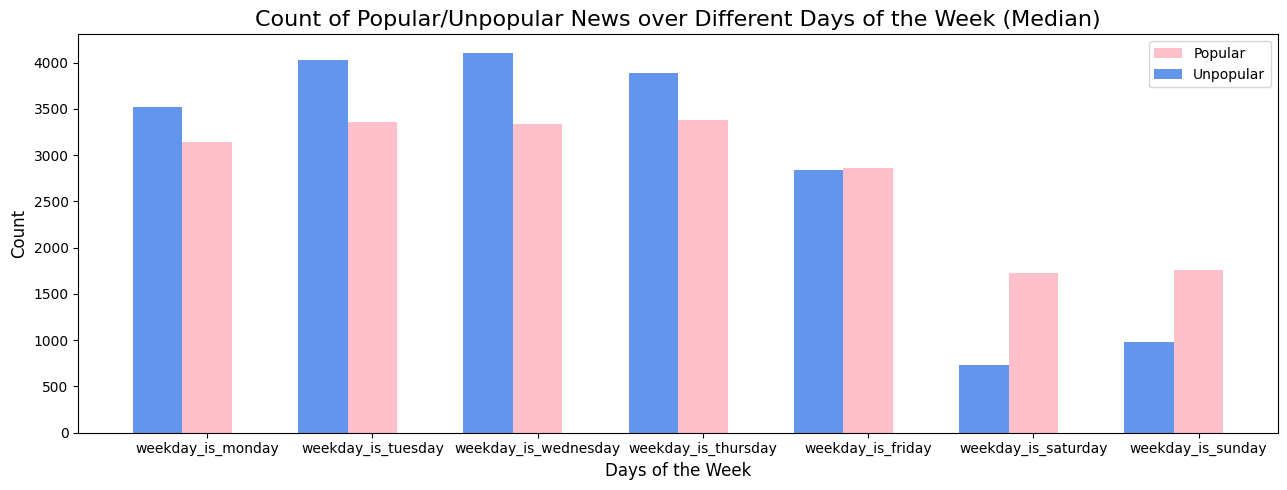

In [131]:
import numpy as np

# Filter the DataFrame for popular and unpopular news
Unpop2 = df.filter(col('popularity_median') == 0)
Pop2 = df.filter(col('popularity_median') == 1)



# Sum the counts for each day of the week
Unpop_day2 = Unpop2.select(Wd).groupBy().sum().collect()[0]
Pop_day2 = Pop2.select(Wd).groupBy().sum().collect()[0]


# Plot the bar chart
fig = plt.figure(figsize=(13, 5))
plt.title("Count of Popular/Unpopular News over Different Days of the Week (Median)", fontsize=16)
plt.bar(np.arange(len(Wd)), Pop_day2, width=0.3, align="center", color='pink', label="Popular")
plt.bar(np.arange(len(Wd)) - 0.3, Unpop_day2, width=0.3, align="center", color='cornflowerblue', label="Unpopular")
plt.xticks(np.arange(len(Wd)), Wd)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Days of the Week", fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [132]:
Dc = df.columns[12:18]
Dc

['data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world']

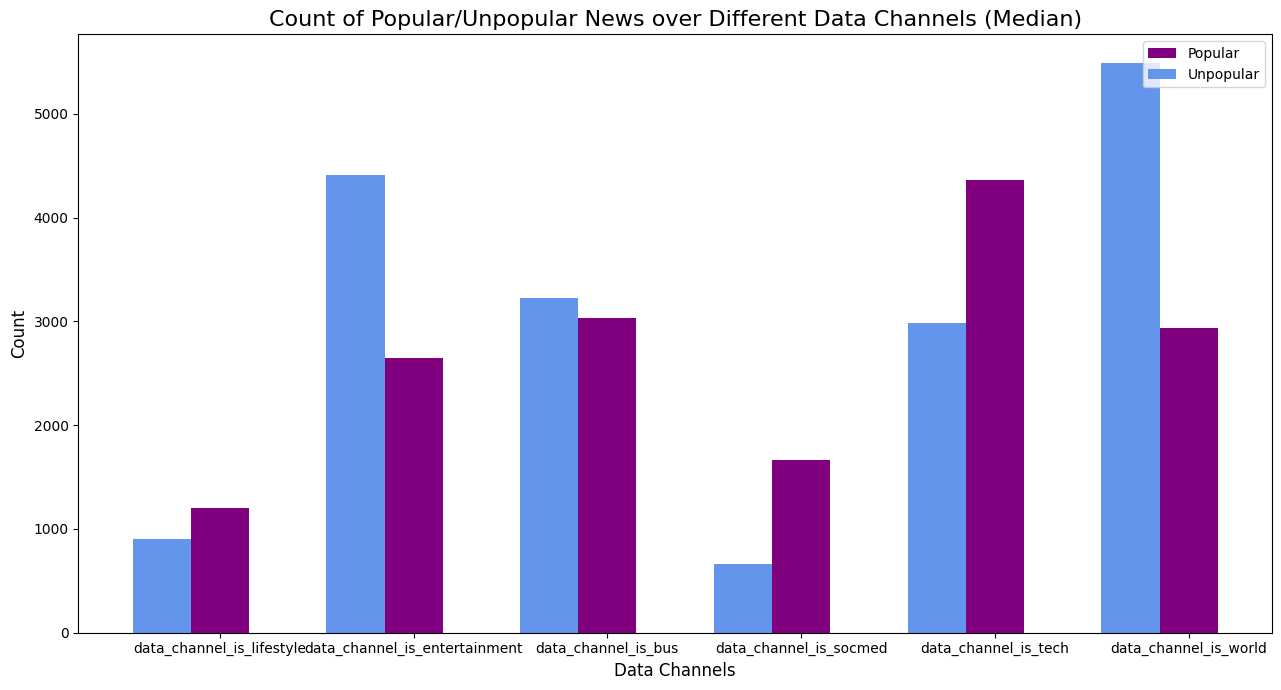

In [133]:
datachannel_count = df.columns[12:18]
Dc

# Summing up the counts for each data channel
Unpop_day4 = Unpop2.select(datachannel_count).groupBy().sum().collect()[0]
Pop_day4 = Pop2.select(datachannel_count).groupBy().sum().collect()[0]



# Plot the bar chart
fig = plt.figure(figsize=(13, 7))
plt.title("Count of Popular/Unpopular News over Different Data Channels (Median)", fontsize=16)
plt.bar(np.arange(len(datachannel_count)), Pop_day4, width=0.3, align="center", color='purple', label="Popular")
plt.bar(np.arange(len(datachannel_count)) - 0.3, Unpop_day4, width=0.3, align="center", color='cornflowerblue', label="Unpopular")
plt.xticks(np.arange(len(datachannel_count)), datachannel_count)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Data Channels", fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


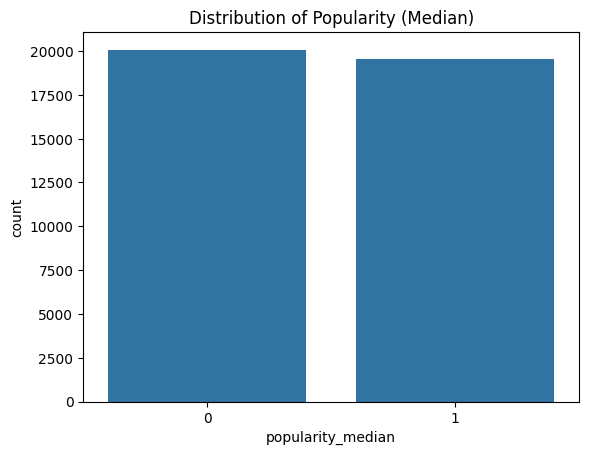

In [134]:
# Select numeric columns for analysis
numeric_columns = df.columns[2:]

# Check the distribution of the target variable
sns.countplot(x="popularity_median", data=df.toPandas())
plt.title("Distribution of Popularity (Median)")
plt.show()

In [137]:
data.printSchema()

root
 |-- url: string (nullable = true)
 |-- timedelta: double (nullable = true)
 |-- n_tokens_title: double (nullable = true)
 |-- n_tokens_content: double (nullable = true)
 |-- n_unique_tokens: double (nullable = true)
 |-- n_non_stop_words: double (nullable = true)
 |-- n_non_stop_unique_tokens: double (nullable = true)
 |-- num_hrefs: double (nullable = true)
 |-- num_self_hrefs: double (nullable = true)
 |-- num_imgs: double (nullable = true)
 |-- num_videos: double (nullable = true)
 |-- average_token_length: double (nullable = true)
 |-- num_keywords: double (nullable = true)
 |-- data_channel_is_lifestyle: double (nullable = true)
 |-- data_channel_is_entertainment: double (nullable = true)
 |-- data_channel_is_bus: double (nullable = true)
 |-- data_channel_is_socmed: double (nullable = true)
 |-- data_channel_is_tech: double (nullable = true)
 |-- data_channel_is_world: double (nullable = true)
 |-- kw_min_min: double (nullable = true)
 |-- kw_max_min: double (nullable = tru

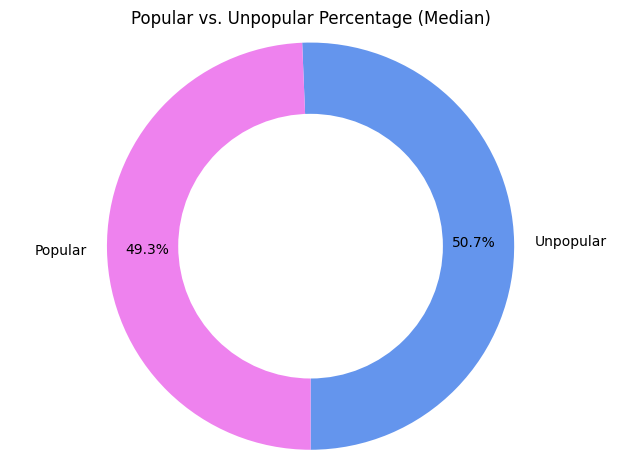

In [140]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import matplotlib.pyplot as plt

# Calculate the number of popular and unpopular news using the median threshold
median_value = df.approxQuantile("shares", [0.5], 0.01)[0]
popular_count = df.filter(col("shares") > median_value).count()
unpopular_count = df.filter(col("shares") <= median_value).count()

#pySpark DataFrame
spark = SparkSession.builder.appName("PopularUnpopularPieChart").getOrCreate()
schema = StructType([StructField("Category", StringType(), True), StructField("Count", IntegerType(), True)])
data = [('Unpopular', unpopular_count),('Popular', popular_count)]
df_pandas = spark.createDataFrame(data, schema=schema).toPandas()

# Create a pie chart
colors = ['cornflowerblue', 'violet']
plt.pie(df_pandas['Count'], labels=df_pandas['Category'], autopct='%1.1f%%', startangle=270, colors=colors, pctdistance=0.8)
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.title("Popular vs. Unpopular Percentage (Median)")
plt.tight_layout()
plt.show()


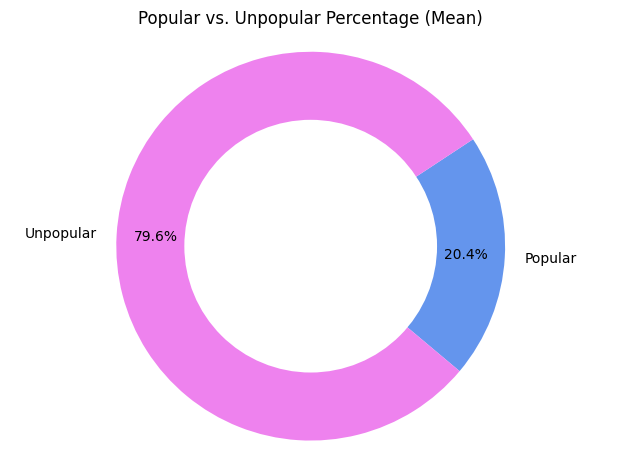

In [ ]:
# Calculate the number of popular and unpopular news using the mean threshold
mean_value = df.agg({"shares": "mean"}).collect()[0][0]
popular_count_mean = df.filter(col("shares") > mean_value).count()
unpopular_count_mean = df.filter(col("shares") <= mean_value).count()

# Create a PySpark DataFrame for visualization with an explicit schema
spark = SparkSession.builder.appName("PopularUnpopularPieChartMean").getOrCreate()
schema_mean = StructType([StructField("Category", StringType(), True), StructField("Count", IntegerType(), True)])
data_mean = [('Popular', popular_count_mean), ('Unpopular', unpopular_count_mean)]
df_pandas_mean = spark.createDataFrame(data_mean, schema=schema_mean).toPandas()

# Create a pie chart for mean threshold
colors_mean = ['cornflowerblue', 'violet']
plt.pie(df_pandas_mean['Count'], labels=df_pandas_mean['Category'], autopct='%1.1f%%', startangle=320, colors=colors_mean, pctdistance=0.8)
centre_circle_mean = plt.Circle((0, 0), 0.65, fc='white')
fig_mean = plt.gcf()
fig_mean.gca().add_artist(centre_circle_mean)
plt.axis('equal')
plt.title("Popular vs. Unpopular Percentage (Mean)")
plt.tight_layout()
plt.show()


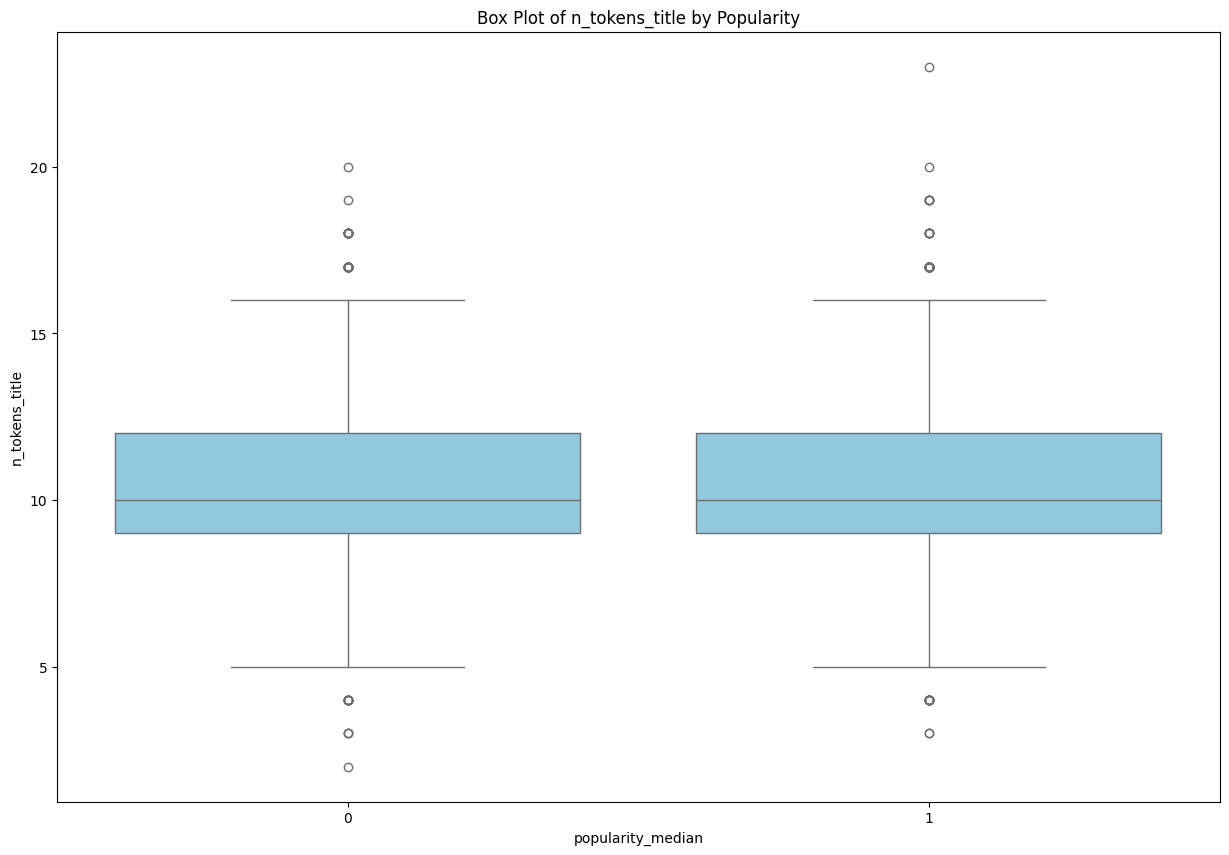

<Figure size 1500x1000 with 0 Axes>

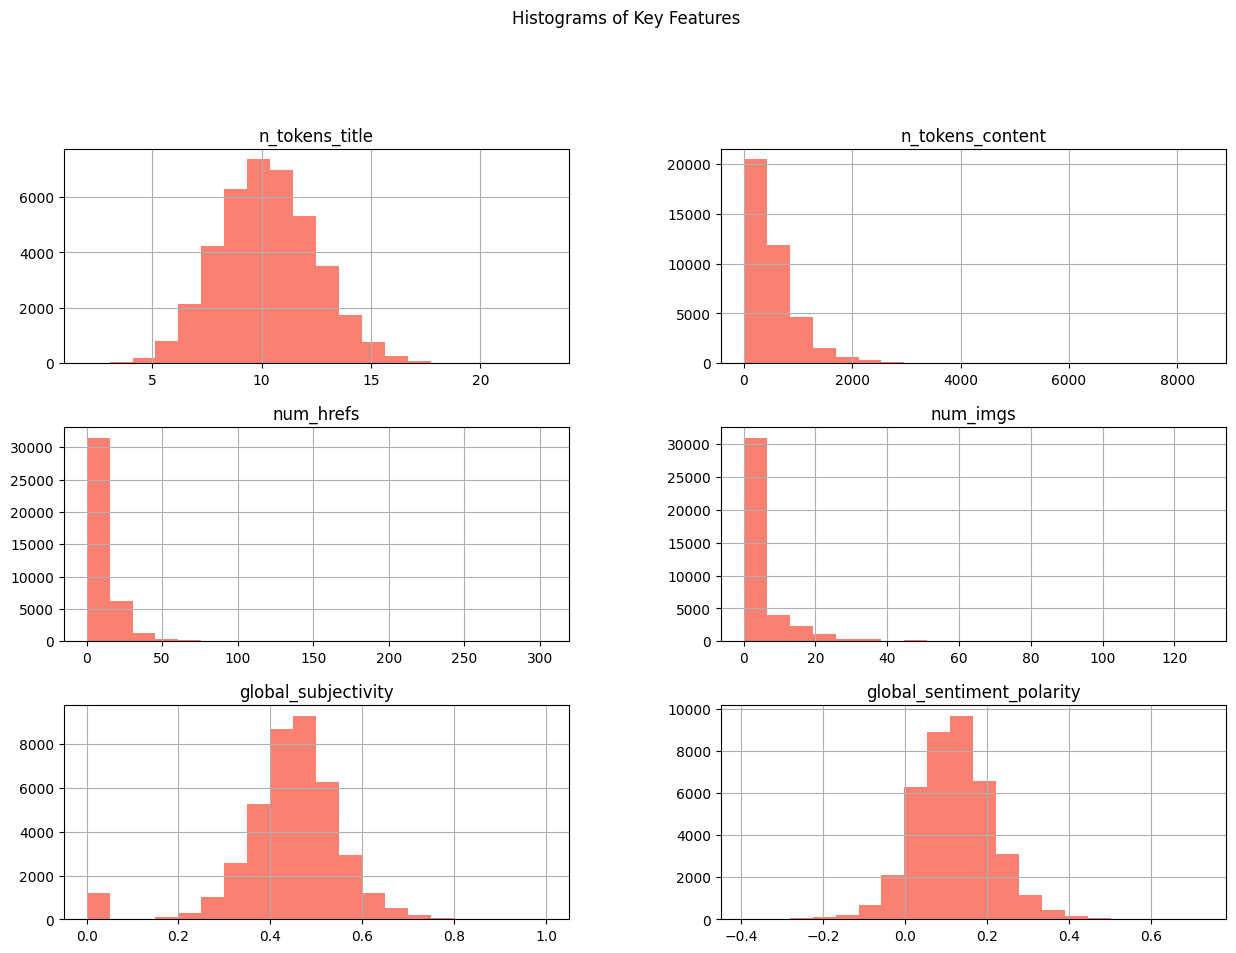

In [141]:
import seaborn as sns

# Selecting key features and the target variable separately
selected_cols = key_Features + ['popularity_median']

# Convert to Pandas for visualization
key_features_data = df.select(*selected_cols).toPandas()

# Shuffle the order of plots
plt.figure(figsize=(15, 10))

# Box plots
sns.boxplot(data=key_features_data, x='popularity_median', y='n_tokens_title', color='skyblue')
plt.title('Box Plot of n_tokens_title by Popularity')
plt.show()

# Histograms with shuffled colors
plt.figure(figsize=(15, 10))
key_features_data[key_Features].hist(bins=20, figsize=(15, 10), color='salmon')
plt.suptitle('Histograms of Key Features', y=1.02)
plt.show()


<h5>4) Feature Engineering

Interaction features by performing mathematical operations (addition, multiplication, etc.) between pairs of numerical features.

In [ ]:
interaction_features = ['num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos']
assembler = VectorAssembler(inputCols=interaction_features, outputCol="interaction_features")
df = assembler.transform(df)

scale numerical features to a standard range (e.g., Min-Max scaling) or normalize them to have a mean of 0 and standard deviation of 1.

In [ ]:
# TScaling and Normalization
scaler = StandardScaler(inputCol="interaction_features", outputCol="scaled_interaction_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

polynomial features can be generated such that raising numerical features to different powers (e.g., square, cube) to capture non-linear relationships.

In [ ]:
# Task 6: Polynomial Features
polynomial_expansion = PolynomialExpansion(inputCol="scaled_interaction_features", outputCol="polynomial_features", degree=2)
df = polynomial_expansion.transform(df)


In [ ]:
# Task 7: Dimensionality Reduction (PCA)
pca = PCA(k=3, inputCol="polynomial_features", outputCol="pca_features")
pca_model = pca.fit(df)
df = pca_model.transform(df)

In [ ]:
selected_features = ["pca_features"]
selected_features.extend(numeric_columns)  # Include original numeric features
selected_features.append("shares")  # Target variable

In [ ]:
df = df.select(selected_features)
df.show()

+--------------------+----------------+---------------+----------------+------------------------+---------+--------------+--------+----------+--------------------+------------+-------------------------+-----------------------------+-------------------+----------------------+--------------------+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------------------+-------------------------+--------------------------+-----------------+------------------+--------------------+-------------------+-----------------+-------------------+-----------------+----------+---------------+---------------+---------------+---------------+---------------+-------------------+-------------------------+--------------------------+--------------------------+-------------------+-------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------

<p><font size = "4">At first we implemented Interaction Features from which We have created interaction features using the selected columns.
Then we performed a Scaling and Normalization, scaling the interaction features to have a mean of 0 and standard deviation of 1.
After that, We generate polynomial features up to degree 2 from the scaled interaction features and perform PCA to reduce the dimensionality of the polynomial features to 3 dimensions. Finally, we select the relevant features and the target variable for further analysis.</p>


<h5>5) Model Building

In [ ]:
train_data , test_data = df.randomSplit([0.8,0.2], seed = 3)
lr = LogisticRegression(featuresCol="pca_features", labelCol="popularity_median")
lr_model = lr.fit(train_data)

6. Model Evalution

 Evaluating the model's performance using metrics such as accuracy, precision, recall, F1 score, and AUC-ROC


In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="popularity_median")

lr_predictions = lr_model.transform(test_data)
lr_auc_roc = evaluator.evaluate(lr_predictions, {evaluator.metricName: "areaUnderROC"})
print("Logistic Regression AUC-ROC:", lr_auc_roc)



Logistic Regression AUC-ROC: 0.5378386759592559


In [ ]:
lr_predictions = lr_predictions.withColumn("popularity_median", col("popularity_median").cast("double"))
#label column,'popularity_median' is of type int, but it's expected to be of type double.
lr_pred_labels = lr_predictions.select("prediction", "popularity_median").rdd.map(tuple)
lr_metrics = MulticlassMetrics(lr_pred_labels)
accuracy = lr_metrics.accuracy

/home/prince/.local/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
print("Accuracy:", accuracy)

print("Precision (Label 0):", lr_metrics.precision(0))
print("Precision (Label 1):", lr_metrics.precision(1))


print("Recall (Label 0):", lr_metrics.recall(0))
print("Recall (Label 1):", lr_metrics.recall(1))


print("F1 Score (Label 0):", lr_metrics.fMeasure(0.0))
print("F1 Score (Label 1):", lr_metrics.fMeasure(1.0))

Accuracy: 0.5289882531261841
Precision (Label 0): 0.5232297788972852
Precision (Label 1): 0.582360570687419
Recall (Label 0): 0.9207091849298202
Recall (Label 1): 0.11644190871369295
F1 Score (Label 0): 0.6672615329704649
F1 Score (Label 1): 0.19407823643829697


In [ ]:
# Select relevant columns for display
prediction_results = lr_predictions.select("popularity_median", "prediction", "num_hrefs", "num_self_hrefs", "num_imgs", "num_videos")

# Show the first few rows of the DataFrame
prediction_results.show()

+-----------------+----------+---------+--------------+--------+----------+
|popularity_median|prediction|num_hrefs|num_self_hrefs|num_imgs|num_videos|
+-----------------+----------+---------+--------------+--------+----------+
|              0.0|       1.0|      5.0|           4.0|     0.0|      74.0|
|              0.0|       1.0|      9.0|           7.0|     1.0|      73.0|
|              1.0|       1.0|     82.0|          74.0|     1.0|       0.0|
|              1.0|       1.0|     76.0|          63.0|     1.0|       0.0|
|              1.0|       1.0|    100.0|          56.0|     1.0|       9.0|
|              1.0|       1.0|     62.0|          53.0|     1.0|       0.0|
|              1.0|       1.0|     62.0|          51.0|     1.0|       0.0|
|              1.0|       1.0|     56.0|          47.0|     1.0|       0.0|
|              0.0|       1.0|      5.0|           4.0|     0.0|      34.0|
|              0.0|       1.0|     53.0|          39.0|    19.0|       0.0|
|           